In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#pip install tensorflow
#pip install pmdarima
#pip install yfinance



In [15]:
# Define the ticker symbol for HUL
ticker_symbol = "ULTRACEMCO.BO"

# Download the historical data
data = yf.download(ticker_symbol, start="2021-04-01", end="2024-03-31")

# Display the first few rows of the data
print(data.head())

# Save the data to a CSV file
data.to_csv("ULTCEM_data.csv")



[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-04-01  6817.700195  6934.299805  6731.700195  6898.450195  6794.735352   
2021-04-05  6850.299805  6993.350098  6737.299805  6794.350098  6692.200684   
2021-04-06  6834.000000  6845.850098  6708.299805  6734.450195  6633.200684   
2021-04-07  6745.000000  6857.000000  6720.000000  6756.450195  6654.870117   
2021-04-08  6809.700195  7049.899902  6788.649902  6976.950195  6872.055176   

            Volume  
Date                
2021-04-01   14367  
2021-04-05   20133  
2021-04-06   13014  
2021-04-07   17489  
2021-04-08   70611  


In [5]:
# Select the Target Variable Adj Close
df = data[['Adj Close']]

# Check for missing values
print("Missing values:")
print(df.isnull().sum())



Missing values:
Adj Close    0
dtype: int64


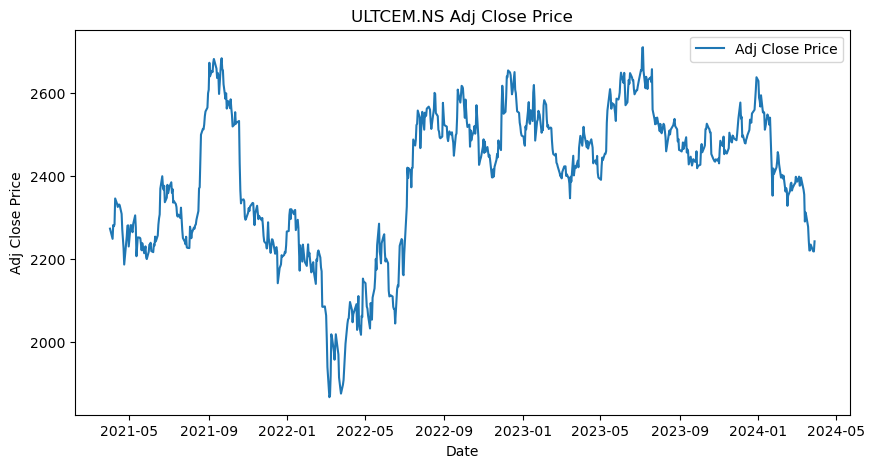

In [16]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df, label='Adj Close Price')
plt.title('ULTCEM.NS Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

# Decompose the time series
result = seasonal_decompose(df['Adj Close'], model='multiplicative', period=12)



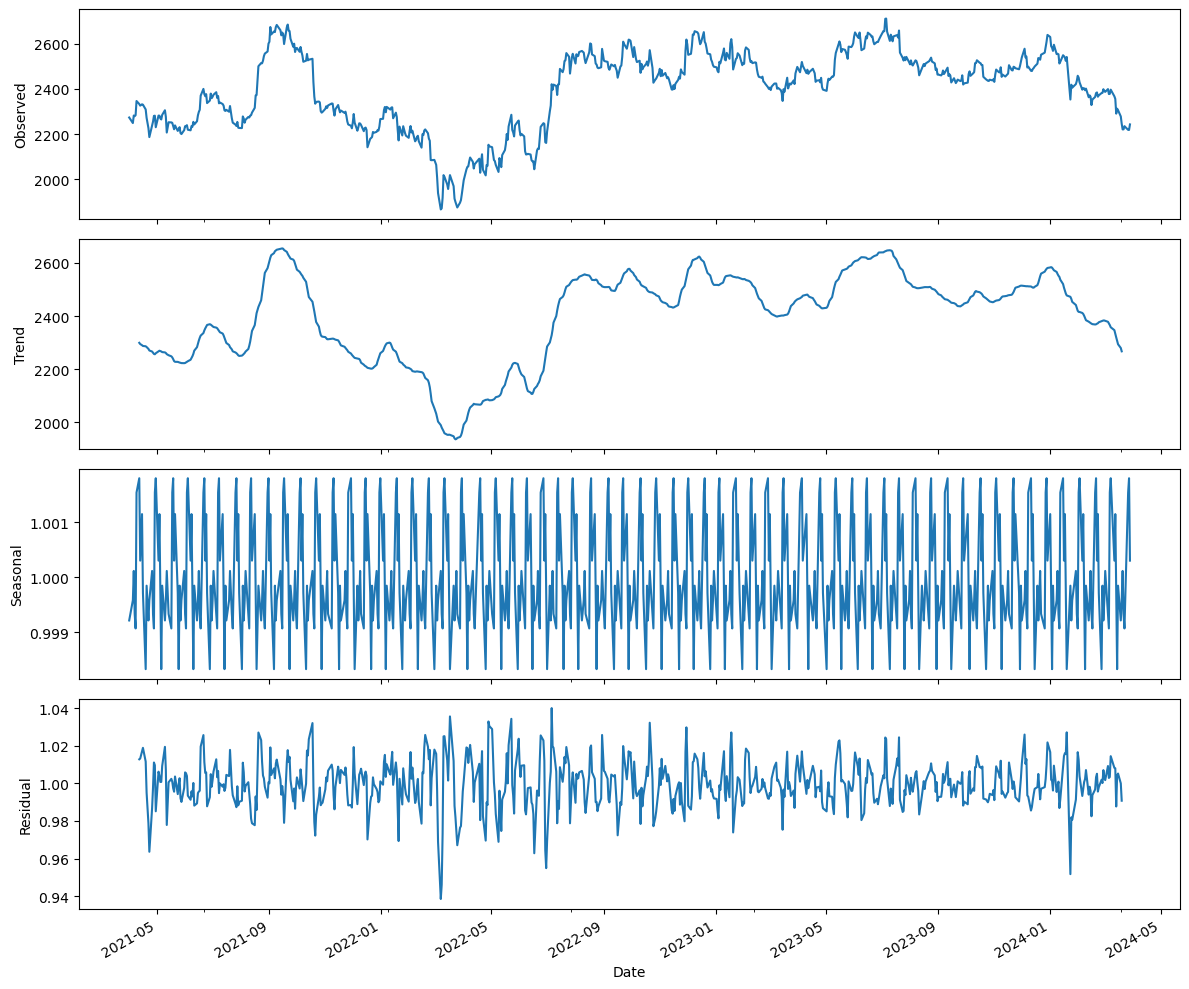

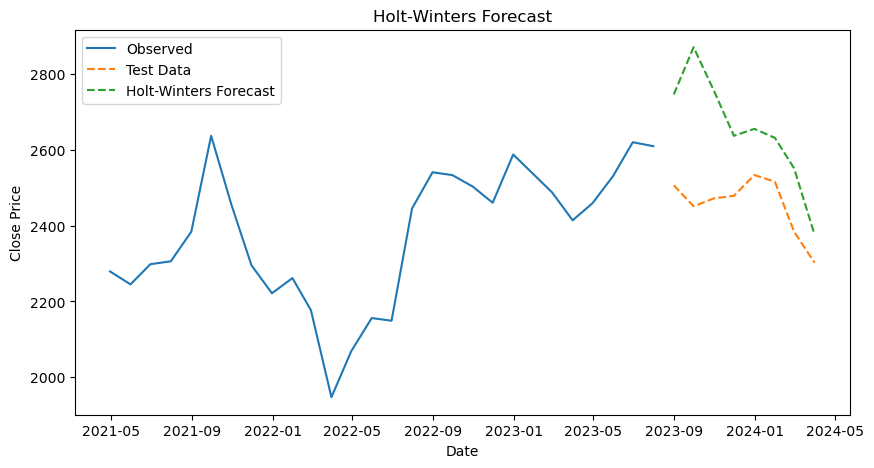

In [7]:
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Resample to monthly data
monthly_data = df.resample("M").mean()

# Split the data into training and test sets
train_data, test_data = train_test_split(monthly_data, test_size=0.2, shuffle=False)

# Fit the Holt-Winters model
holt_winters_model = ExponentialSmoothing(train_data, seasonal='mul', seasonal_periods=12).fit()

# Forecast for the next year (12 months)
holt_winters_forecast = holt_winters_model.forecast(len(test_data))

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(train_data, label='Observed')
plt.plot(test_data.index, test_data, label='Test Data', linestyle='--')
plt.plot(test_data.index, holt_winters_forecast, label='Holt-Winters Forecast', linestyle='--')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()



In [8]:
# Compute RMSE, MAE, MAPE, R-squared for Holt-Winters model
rmse = np.sqrt(mean_squared_error(test_data, holt_winters_forecast))
mae = mean_absolute_error(test_data, holt_winters_forecast)
mape = np.mean(np.abs((test_data - holt_winters_forecast) / test_data)) * 100
r2 = r2_score(test_data, holt_winters_forecast)
print(f'Holt-Winters - RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, R-squared: {r2}')

# Fit auto_arima model
arima_model = auto_arima(train_data['Adj Close'], 
                         seasonal=True, 
                         m=12,  # Monthly seasonality
                         stepwise=True, 
                         suppress_warnings=True)

# Print the model summary
print(arima_model.summary())

# Generate forecast
n_periods = len(test_data)
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)



Holt-Winters - RMSE: 223.82250125036546, MAE: 197.5451877236673, MAPE: nan, R-squared: -8.591472694997982
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -171.762
Date:                Mon, 22 Jul 2024   AIC                            349.524
Time:                        22:09:23   BIC                            353.520
Sample:                    04-30-2021   HQIC                           350.746
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    463.6250    307.295      1.509      0.131    -138.662    1065.912
ar.L1          0.8062    

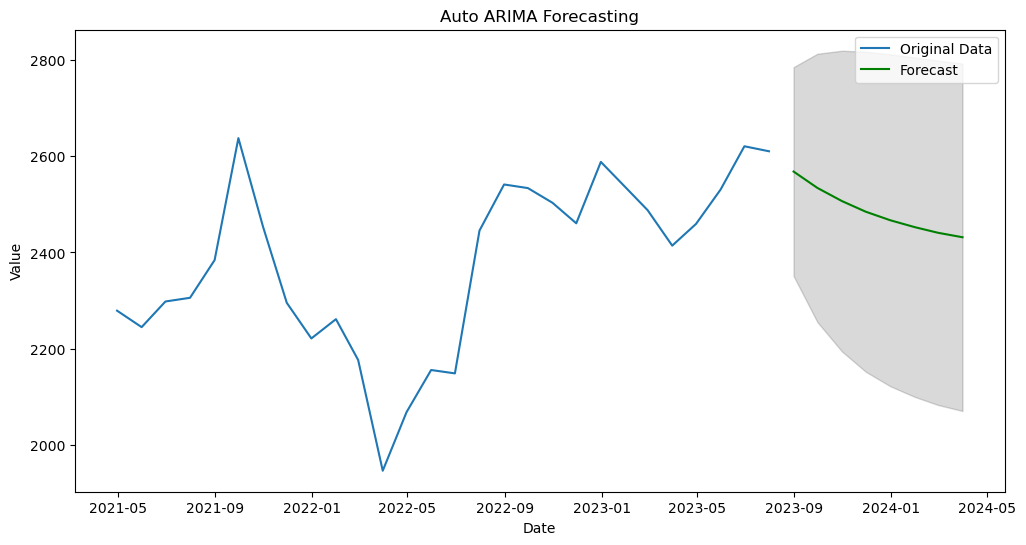

ARIMA - RMSE: 70.92173996290344, MAE: 62.54480986329321, MAPE: nan, R-squared: 0.03697720078911604


In [9]:
# Plot the original data, fitted values, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data['Adj Close'], label='Original Data')
plt.plot(test_data.index, forecast, label='Forecast', color='green')
plt.fill_between(test_data.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='k', alpha=.15)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Auto ARIMA Forecasting')
plt.show()

# Compute RMSE, MAE, MAPE, R-squared for ARIMA model
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
r2 = r2_score(test_data, forecast)
print(f'ARIMA - RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, R-squared: {r2}')

# Daily data processing
daily_data = df.copy()



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  740
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3554.457
Date:                Mon, 22 Jul 2024   AIC                           7110.915
Time:                        22:09:33   BIC                           7115.520
Sample:                             0   HQIC                          7112.690
                                - 740                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       881.6249     28.342     31.107      0.000     826.076     937.174
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               327.39
Prob(Q):                              0.57   Pr

C:\Users\mohit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mohit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


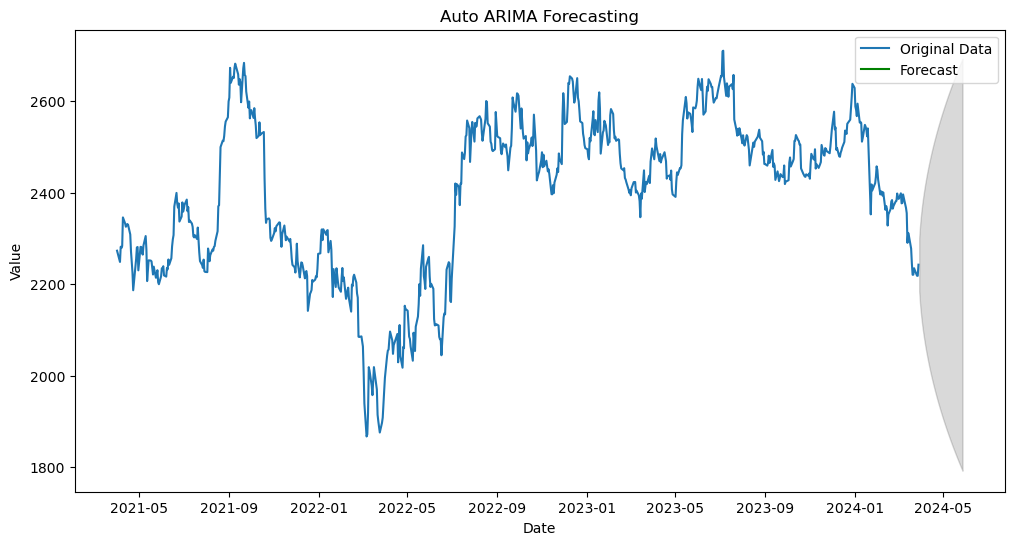

In [10]:
# Fit auto_arima model for daily data
arima_model = auto_arima(daily_data['Adj Close'], 
                         seasonal=True, 
                         m=7,  # Weekly seasonality
                         stepwise=True, 
                         suppress_warnings=True)

# Print the model summary
print(arima_model.summary())

# Generate forecast
n_periods = 60  # Forecast the next 60 days
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Create future dates index
last_date = daily_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_periods)

# Convert forecast to a DataFrame with future_dates as the index
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['forecast'])
conf_int_df = pd.DataFrame(conf_int, index=future_dates, columns=['lower_bound', 'upper_bound'])

# Plot the original data, fitted values, and forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Adj Close'], label='Original Data')
plt.plot(forecast_df, label='Forecast', color='green')
plt.fill_between(future_dates, 
                 conf_int_df['lower_bound'], 
                 conf_int_df['upper_bound'], 
                 color='k', alpha=.15)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Auto ARIMA Forecasting')
plt.show()



In [11]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select features (excluding 'Adj Close') and target ('Adj Close')
features = data.drop(columns=['Adj Close'])
target = data[['Adj Close']]

# Fit the scaler on features and target
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target)

# Create DataFrame with scaled features and target
scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=df.index)
scaled_df['Adj Close'] = scaled_target

# Function to create sequences
def create_sequences(scaled_df, target_col, sequence_length):
    sequences = []
    labels = []
    for i in range(len(scaled_df) - sequence_length):
        sequences.append(scaled_df.iloc[i:i + sequence_length].values)
        labels.append(scaled_df.iloc[i + sequence_length, target_col])  # Target column index
    return np.array(sequences), np.array(labels)

# Define the target column index and sequence length
target_col = scaled_df.columns.get_loc('Adj Close')
sequence_length = 30



In [12]:
# Create sequences
X, y = create_sequences(scaled_df, target_col, sequence_length)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()



C:\Users\mohit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict on the test set
y_pred = model.predict(X_test)



Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 0.1397 - val_loss: 0.0287
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0167 - val_loss: 0.0069
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0255 - val_loss: 0.0034
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0204 - val_loss: 0.0029
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0154 - val_loss: 0.0029
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0162 - val_loss: 0.0052
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0184 - val_loss: 0.0040
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0185 - val_loss: 0.0031
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0163 - val_loss: 0.0026
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0130 - val_loss: 0.0025
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0131 - val_loss: 0.0027
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0

In [14]:
# Inverse transform the predictions and true values to get them back to the original scale
y_test_scaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), features.shape[1])), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_scaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), features.shape[1])), y_pred), axis=1))[:, -1]

# Compute RMSE, MAE, MAPE, R-squared for LSTM model
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
mape = np.mean(np.abs((y_test_scaled - y_pred_scaled) / y_test_scaled)) * 100
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f'LSTM - RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, R-squared: {r2}')


LSTM - RMSE: 38.18742870168935, MAE: 29.13279473064489, MAPE: 1.1930245620320479, R-squared: 0.7971825571522422
